In [1]:
!jt -r
# from jupyterthemes import jtplot
# jtplot.style()

Reset css and font defaults in:
C:\Users\Justin\.jupyter\custom &
C:\Users\Justin\AppData\Roaming\jupyter\nbextensions


In [2]:
# IMPORTS
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import matplotlib.pyplot as plt
import numpy as np
import pickle
import scipy.linalg
import torch
import time
from tqdm import trange
import torch.nn as nn

import warnings
warnings.filterwarnings('ignore')

# PATH
import sys
sys.path.append('../../')
from sci.lib.loader import *
from sci.lib.recorder import * 
from sci.lib.utils import *

from sci.lib.seq.helper import *
from sci.lib.seq.models import *
from sci.lib.seq.parser import *

from sci.lib.vis.modes import *
from sci.lib.vis.post import *
from sci.lib.vis.reconstruct import *

# SETTINGS
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams.update({'font.size':28})
DPI = 60

#GLOBALS
VKS_DIR = '../data/VKS.pkl'

# Data

## Data Loading


In [3]:
with open(VKS_DIR, 'rb') as f:
    vks = pickle.load(f)
vks = np.nan_to_num(vks)
shape = vks.shape
print('Data Shape: {}'.format(shape))

Data Shape: (505, 279, 400, 3)



## Data Visualization

In [4]:
def vks_plot(vks_t):
    plt.figure(figsize=(10, 6), dpi=80)
    plt.subplot(121)
    plt.imshow(vks[:,:,vks_t,0])
    plt.title('Velocity in X direction')
    
    plt.subplot(122)
    plt.imshow(vks[:,:,vks_t,1])
    plt.title('Velocity in Y direction')

    # plt.subplot(133)
    # plt.imshow(vks[:,:,vks_t,2])
    # plt.title('Density?')

interact_manual(vks_plot, vks_t = widgets.IntSlider(value=100,
                                               min=0,
                                               max=vks.shape[2]-1,
                                               step=1))

interactive(children=(IntSlider(value=100, description='vks_t', max=399), Button(description='Run Interact', s…

<function __main__.vks_plot(vks_t)>

## Dynamic Mode Decomposition

### Method

In [111]:
def DMD(X, Xp, modes):

    U,Sigma,V = np.linalg.svd(X, full_matrices=False, compute_uv=True)
    Ur = U[:,:modes]
    Sigmar = np.diag(Sigma[:modes]    )
    Vr = V[:modes,:].T

    invSigmar = np.linalg.inv(Sigmar)


    Atilde = Ur.T@Xp@Vr@invSigmar
    Lambda, W = np.linalg.eig(Atilde)
    Lambda = np.diag(Lambda)

    Phi = Xp@(Vr@invSigmar)@W

    alpha1 = Sigmar@(Vr[0,:].T)
    b = np.linalg.solve(W@Lambda,alpha1)

    return Atilde, Ur, Phi, Lambda, b


In [112]:
s_ind = 100
e_ind = 200

In [118]:
var1 = vks[:, :, s_ind:e_ind, 0]
var1 = np.moveaxis(var1, [0, 1, 2], [1, 2, 0])

var2 = vks[:, :, s_ind:e_ind, 1]
var2 = np.moveaxis(var2, [0, 1, 2], [1, 2, 0])

var1_mean = np.mean(var1, axis=0)[np.newaxis, ...]
var2_mean = np.mean(var2, axis=0)[np.newaxis, ...]

var1 = var1-var1_mean
var2 = var2-var2_mean

var1_copy = var1.copy()
var2_copy = var2.copy()

shape = var1.shape
var1 = var1.reshape(shape[0], shape[1] * shape[2])
var2 = var2.reshape(shape[0], shape[1] * shape[2])
Y = np.hstack((var1, var2))

Ux_DMD = var1.copy()
Uy_DMD = var2.copy()

Atilde, Ur, Phi, Lambda, b = DMD(Y[:-1,:].T, Y[1:,:].T, 6)

(6,) (6, 6)


In [119]:
print(b.shape)

(6,)


(281790, 6) (6, 6) (6,)


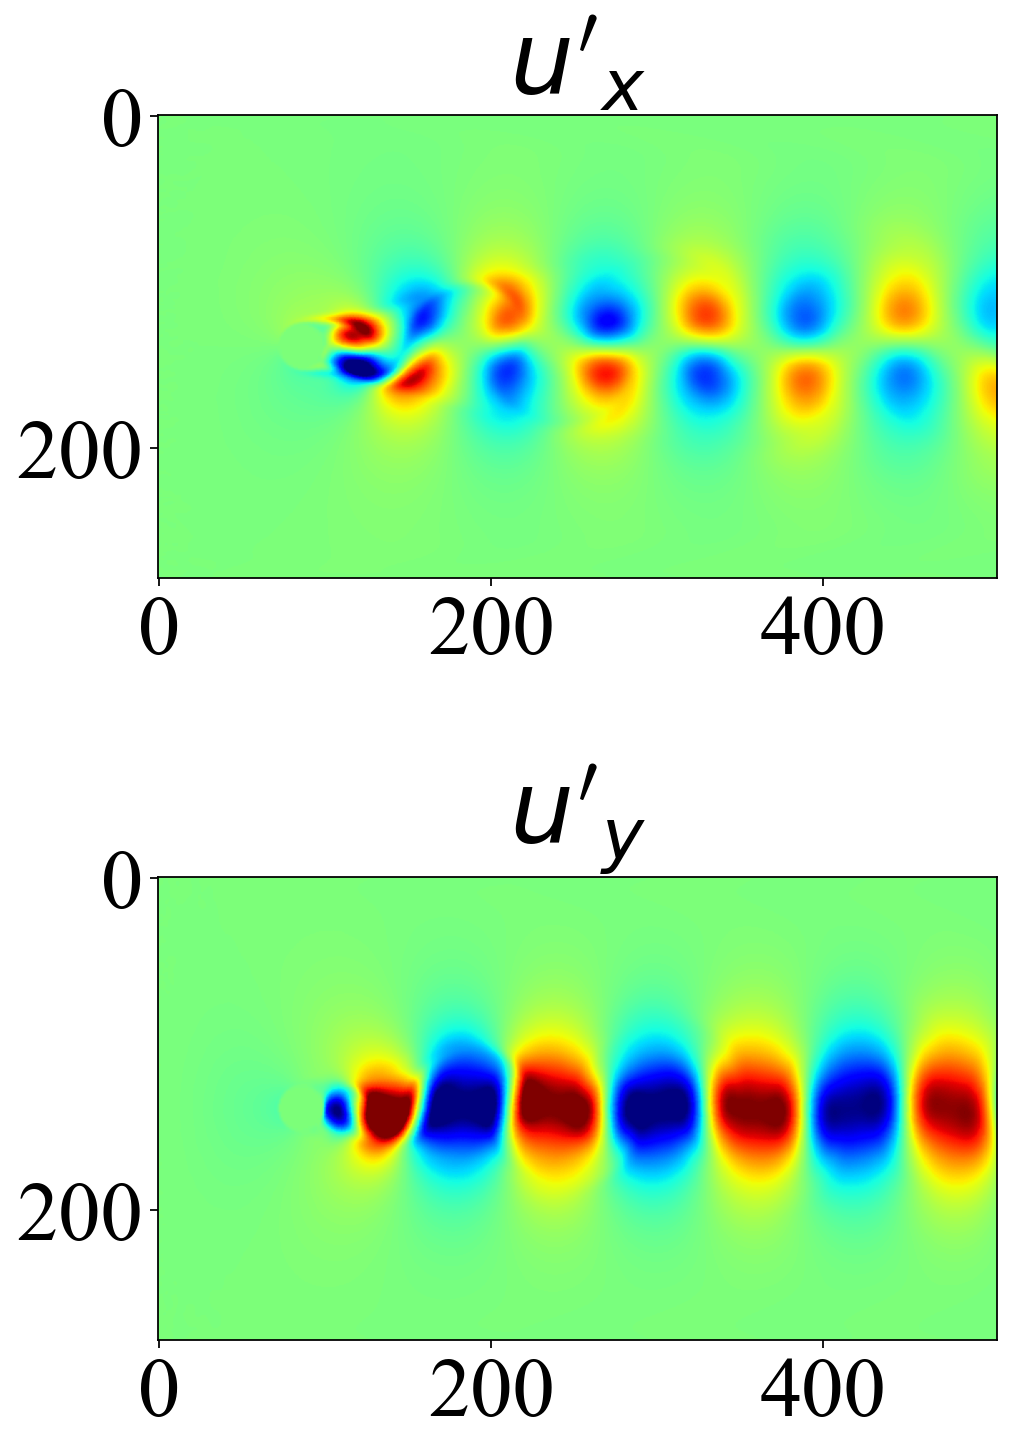

In [121]:
n = 20
print(Phi.shape, Lambda.shape, b.shape)
x = np.real(Phi@Lambda@b)
Nxy = shape[1]*shape[2]
vx = x[:Nxy].reshape(shape[1],shape[2])
vy = x[Nxy:].reshape(shape[1],shape[2])

plt.rcParams['font.size'] = 38

plt.figure(figsize=(10,10), tight_layout=True, dpi=160)
plt.subplot(211)
plt.imshow(var1_copy[99].T, origin='upper', cmap='jet', vmin =-.4, vmax = .4)
plt.title('$u\'_x$')

plt.subplot(212)
plt.imshow(var2_copy[99].T, origin='upper', cmap='jet', vmin =-.4, vmax = .4)
plt.title('$u\'_y$')
plt.savefig('../out/VKS/true_200.pdf', format="pdf", bbox_inches="tight")

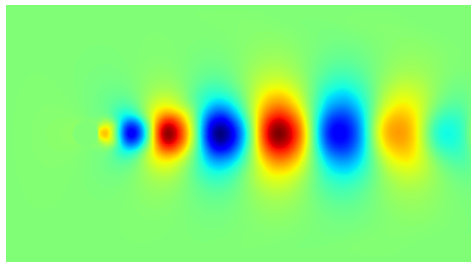

In [10]:
n = 20
Afuture = np.linalg.matrix_power(Atilde,n)
xr = Afuture@Ur.T@Y[-1,:]

x = Ur@xr
Nxy = shape[1]*shape[2]
vx = x[:Nxy].reshape(shape[1],shape[2])
vy = x[Nxy:].reshape(shape[1],shape[2])

plt.figure(figsize=(10,10), dpi=60)
# plt.subplot(221)
plt.imshow(vy.T, origin='upper', cmap='jet')
plt.axis('off')
plt.savefig('../out/VKS/dmd_mode1.png', bbox_inches="tight")
# plt.title('DMD U_x')

# plt.subplot(222)
# plt.imshow(vy.T, origin='upper')
# plt.title('DMD U_y')

# plt.subplot(223)
# plt.imshow(vks[:,:,s_ind+e_ind+n-1,0].T, origin='upper')
# plt.title('True U_x')

# plt.subplot(224)
# plt.imshow(vks[:,:,s_ind+e_ind+n-1,1].T, origin='upper')
# plt.title('True U_y')

## Proper Orthogonal Decomposition

### Method

In [ ]:
def POD2(data, s_ind, e_ind, modes):
    """ Computes the spatial modes and temporal coefficients using the POD """
    # velocity in x
    var1 = data[:, :, s_ind:e_ind, 0]
    var1 = np.moveaxis(var1, [0, 1, 2], [1, 2, 0])

    # velocity in y
    var2 = data[:, :, s_ind:e_ind, 1]
    var2 = np.moveaxis(var2, [0, 1, 2], [1, 2, 0])

    # taking the temporal mean of snapshots
    var1_mean = np.mean(var1, axis=0)[np.newaxis, ...]
    var2_mean = np.mean(var2, axis=0)[np.newaxis, ...]

    # fluctuating components: taking U-Um
    var1 = var1 - var1_mean
    var2 = var2 - var2_mean
    
    # return copies
    var1_copy = np.copy(var1)
    var2_copy = np.copy(var2)

    # Reshaping to create snapshot matrix Y with dimension [time, NxM]
    shape = var1.shape
    var1 = var1.reshape(shape[0], shape[1] * shape[2])
    var2 = var2.reshape(shape[0], shape[1] * shape[2])
    Y = np.hstack((var1, var2))

    # Snapshot Method:
    Cs = np.matmul(Y, Y.T)

    # L:eigvals, As:eigvecs
    Lv, As = scipy.linalg.eigh(Cs)

    # descending order
    Lv = Lv[Lv.shape[0]::-1]
    As = As[:, Lv.shape[0]::-1]

    spatial_modes = np.matmul(Y.T, As[:, :modes]) / np.sqrt(Lv[:modes])
    temporal_coefficients = np.matmul(Y, spatial_modes) #"throw sqrt of Lv onto temp_coef"

    return spatial_modes, temporal_coefficients, Lv, var1_copy, var2_copy


### Reduced VKS Data

From $t=0$ to $t=500$

In [13]:
s_ind = 100
e_ind = 400
print(vks.shape)
Nxy = shape[1]*shape[2]
pod_modes = 16
spatial_modes, data, eigenvalues, Ux_MS, Uy_MS = POD2(vks, s_ind, e_ind, pod_modes)
print("REDUCED MODEL SHAPE: {}".format(data.shape))


(505, 279, 400, 3)
REDUCED MODEL SHAPE: (300, 16)


### Visualization of Reduced Data

In [ ]:
pod_true = np.matmul(data, spatial_modes.T)
print(pod_true.shape)
pod_x = pod_true[:, :Nxy]
pod_y = pod_true[:, Nxy:]

shape = [pod_true.shape[0], vks.shape[0], vks.shape[1]]

pod_x = pod_x.reshape(shape[0], shape[1], shape[2])
pod_y = pod_y.reshape(shape[0], shape[1], shape[2])
# Ux_DMD = Ux_DMD.reshape(shape[0], shape[1], shape[2])
# Uy_DMD = Uy_DMD.reshape(shape[0], shape[1], shape[2])

(300, 281790)


### Comparison of ROMs

In [ ]:
print(Ux_DMD.shape)
print(Ux_MS.shape)

(400, 140895)
(300, 505, 279)


In [ ]:
def vks_Reconstructed(rec_vks_t):
    plt.figure(figsize=(10,10), tight_layout=True)

    plt.subplot(221)
    plt.imshow(Ux_MS[rec_vks_t,:,:], origin='upper', cmap='jet', vmin =-.4, vmax = .4)
    plt.title('ROM U_x')

    plt.subplot(222)
    plt.imshow(Ux_DMD[rec_vks_t,:,:], origin='upper', cmap='jet', vmin =-.4, vmax = .4)
    plt.title('True U_x')

    plt.subplot(223)
    plt.imshow(Uy_MS[rec_vks_t,:,:], origin='upper', cmap='jet', vmin =-.4, vmax = .4)
    plt.title('ROM U_y')

    plt.subplot(224)
    plt.imshow(Uy_DMD[rec_vks_t,:,:], origin='upper', cmap='jet', vmin =-.4, vmax = .4)
    plt.title('True U_y')

interact_manual(vks_Reconstructed, rec_vks_t = widgets.IntSlider(value=0,
                                               min=0,
                                               max=vks.shape[2]-1,
                                               step=1))

NameError: name 'interact_manual' is not defined

### Mean Subtracted FOM vs ROM

In [ ]:
def vks_fullReduced(vks_t):

    plt.figure(figsize=(10,10), tight_layout=True)
    plt.subplot(221)
    plt.imshow(Ux_MS[vks_t,:,:], origin='upper', cmap='jet', vmin =-.4, vmax = .4)
    plt.title('FOM U_x')
    plt.subplot(222)
    plt.imshow(pod_x[vks_t,:,:], origin='upper', cmap='jet', vmin =-.4, vmax = .4)
    plt.title('ROM U_x')
    plt.subplot(223)
    plt.imshow(Uy_MS[vks_t,:,:], origin='upper', cmap='jet', vmin =-.4, vmax = .4)
    plt.title('FOM U_y')
    plt.subplot(224)
    plt.imshow(pod_y[vks_t,:,:], origin='upper', cmap='jet', vmin =-.4, vmax = .4)
    plt.title('ROM U_y')

interact_manual(vks_fullReduced, vks_t = widgets.IntSlider(value=100,
                                               min=0,
                                               max=vks.shape[2]-1,
                                               step=1))

interactive(children=(IntSlider(value=100, description='vks_t', max=399), Button(description='Run Interact', s…

<function __main__.vks_fullReduced(vks_t)>

### Animation FOM v ROM

IndexError: too many indices for array: array is 2-dimensional, but 3 were indexed

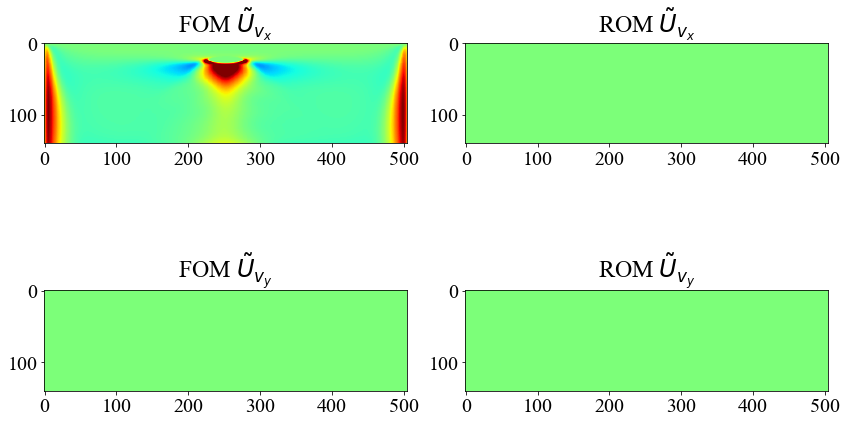

In [ ]:
fig, axes = plt.subplots(2,2, figsize=(12,12), tight_layout=True)
fig.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=None, hspace=None)
titles = ['FOM $\\tilde{U}_{v_x}$', 'ROM $\\tilde{U}_{v_x}$', 'FOM $\\tilde{U}_{v_y}$', 'ROM $\\tilde{U}_{v_y}$']
lines = []
for i,ax in enumerate(axes.flatten()):
    ax.set_title(titles[i])
    lines = lines + [ax.imshow(np.zeros((shape[0],shape[1])), origin='upper', cmap='jet', vmin =-.4, vmax = .4)]
    

def run(vks_t):

    lines[0].set_data(Ux_MS[vks_t,:,:])
    lines[1].set_data(pod_x[vks_t,:,:])
    lines[2].set_data(Uy_MS[vks_t,:,:])
    lines[3].set_data(pod_y[vks_t,:,:])

    return lines


ani = animation.FuncAnimation(fig, run, blit=True,
    repeat=False)
ani.save('../out/VKS/anim_rom.gif', "PillowWriter", fps=5)


### Single Frame Save

NameError: name 'titles' is not defined

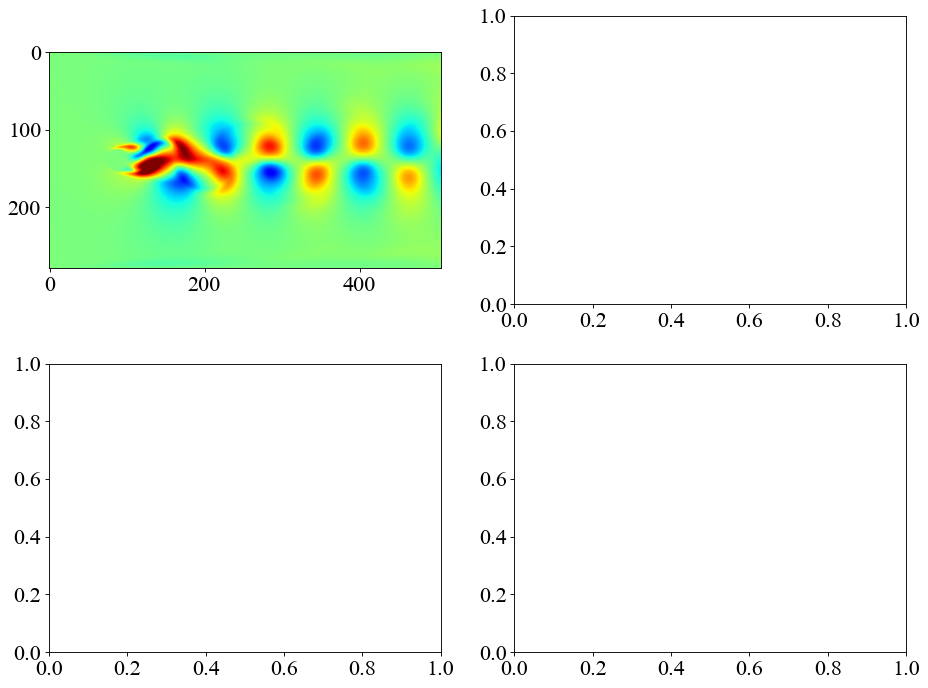

In [13]:
frame = 120
fig, axes = plt.subplots(2,2, figsize=(12,9), tight_layout=True, dpi=80)
fig.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=None, hspace=None)
axes[0,0].imshow(Ux_MS[frame,:,:].T, origin='upper', cmap='jet', vmin =-.4, vmax = .4)
axes[0,0].set_title(titles[0])
axes[0,1].imshow(pod_x[frame,:,:].T, origin='upper', cmap='jet', vmin =-.4, vmax = .4)
axes[0,1].set_title(titles[1])
axes[1,0].imshow(Uy_MS[frame,:,:].T, origin='upper', cmap='jet', vmin =-.4, vmax = .4)
axes[1,0].set_title(titles[2])
axes[1,1].imshow(pod_y[frame,:,:].T, origin='upper', cmap='jet', vmin =-.4, vmax = .4)
axes[1,1].set_title(titles[3])

plt.savefig('../out/VKS/romframe.pdf')

## Plot of POD Modes

In [14]:
print(np.linalg.norm(data[:,0]))
print(np.linalg.norm(data[:,1]))
print(np.linalg.norm(data[:,2]))
print(np.linalg.norm(data[:,3]))

308.86133
307.44336
221.39078
106.347885


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


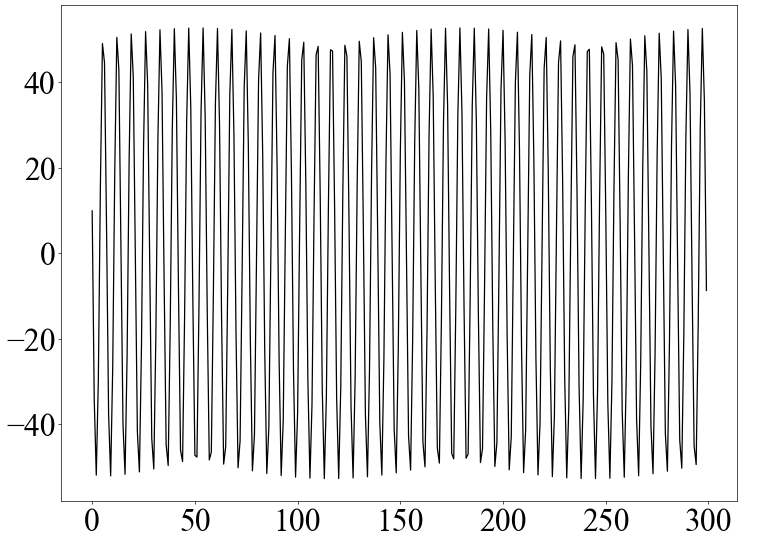

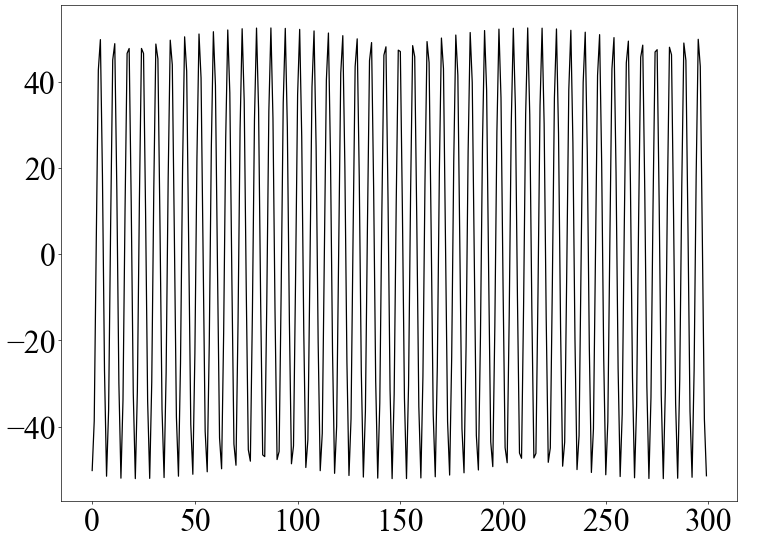

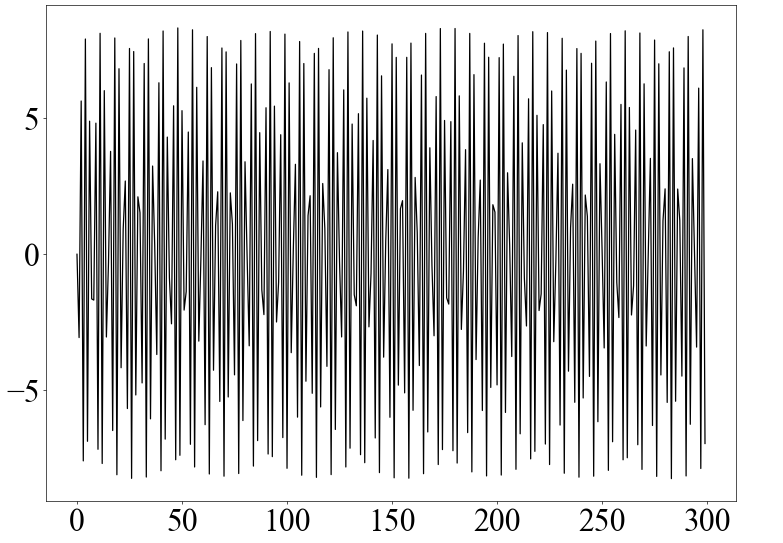

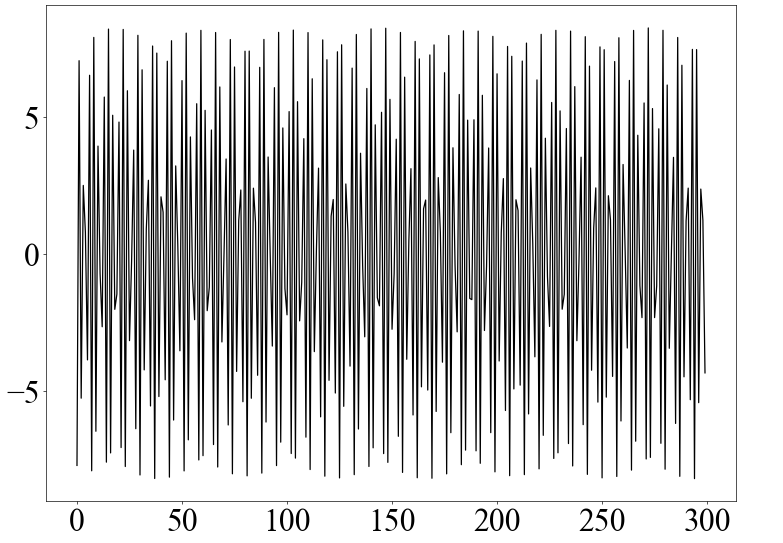

In [18]:
# set_modes = pod_modes
set_modes = 4
m=2
n = pod_modes//m
# plt.suptitle("VKS Modes")
for i in range(set_modes):
    plt.figure(figsize=(7*set_modes//2,10), tight_layout=True, dpi=DPI)
    plt.plot(data[:,i], 'k')
    # plt.axis('off')
    # plt.xlabel("Time ($t$)")
    # plt.ylabel("$\\alpha_{}$".format(i))
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0., prop={'size': 10}, frameon=False)
    plt.savefig('../out/VKS/podMode{}.jpg'.format(i), bbox_inches="tight")
    # plt.title('MODE {}'.format(i+1))

## Plot of POD Mode Loss

0.030886882588962432


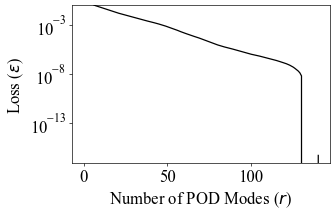

In [16]:
total = sum(eigenvalues)
eig_data = []
cumulative=[1]

for eig in eigenvalues:
    val = eig/total
    eig_data = eig_data + [val]
    cumulative = cumulative + [cumulative[-1]-val]

x = np.arange(0,len(eig_data))
x2 = np.arange(0,len(cumulative))

#CUMULATIVE PLOT
plt.figure(tight_layout=True, dpi=DPI)
# plt.title("VKS ROM Recovery Loss")
plt.yscale('log')
plt.plot(x2,cumulative, 'k')
plt.ylim(0,.1)
plt.xlabel('Number of POD Modes ($r$)')
plt.ylabel('Loss ($\\varepsilon$)')
plt.savefig('../out/VKS/pod_loss.pdf', format="pdf", bbox_inches="tight")

print(cumulative[15])

# Model

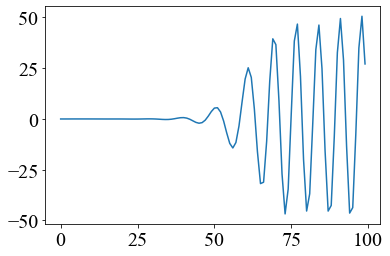

In [15]:
seq_win = 26
tr_win = 100
val_win = 150
device = 'cpu'
plt.plot(data[:100,0])

In [16]:
total_size = data.shape[0] - seq_win
#SEQUENCE DATA
seq_data = np.vstack([[data[t:t + seq_win, :] for t in range(total_size-1)]]).swapaxes(0,1)
seq_label = np.vstack([[data[t+seq_win:t+seq_win+1, :] for t in range(total_size-1)]]).swapaxes(0,1)
print(seq_label.shape)


(1, 113, 16)


(26, 113, 16) (1, 113, 16)


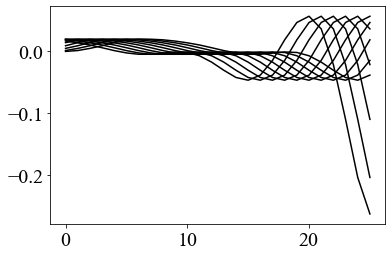

In [17]:
print(seq_data.shape, seq_label.shape)
plt.plot(seq_data[:,:10,0],'k')
plt.show()

In [18]:
# training data
train_data = seq_data[:, :tr_win-seq_win, :]
train_label = seq_label[:, :tr_win-seq_win, :]
train_data =  torch.FloatTensor(train_data).to(device)
train_label = torch.FloatTensor(train_label).to(device)
train_times = (torch.ones(train_data.shape[:-1])/train_data.shape[1]).to(device)

torch.Size([1])


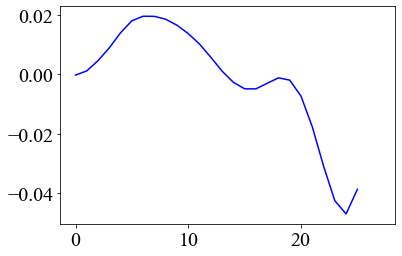

In [19]:
print(train_label[:,0,0].shape)
plt.plot(train_data[:,0,0], color='b')
plt.plot([seq_win+1],train_label[:,0,0], 'r')

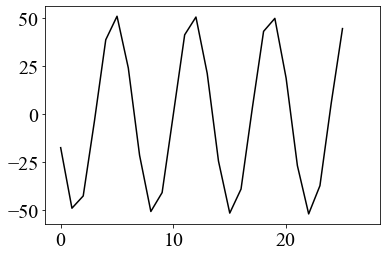

In [20]:
# validation data
val_data = seq_data[:, tr_win:val_win-seq_win, :]
val_label = seq_label[:, tr_win:val_win-seq_win, :]
val_data =  torch.FloatTensor(val_data).to(device)
val_label = torch.FloatTensor(val_label).to(device)
val_times = (torch.ones(val_data.shape[:-1])/val_data.shape[1]).to(device)
plt.plot(val_data[:,0,0], color='k')
plt.plot(seq_win+1,val_label[:,0,0], 'r--', alpha=.75)

In [21]:
# validation data
eval_data = seq_data[:, val_win:, :]
eval_label = seq_label[:, val_win:, :]
eval_data =  torch.FloatTensor(eval_data).to(device)
eval_label = torch.FloatTensor(eval_label).to(device)
eval_times = (torch.ones(eval_data.shape[:-1])/eval_data.shape[1]).to(device)

In [22]:
print(train_data.shape, train_times.shape, train_label.shape)
print(val_data.shape, val_label.shape)
print(eval_data.shape, eval_label.shape)

torch.Size([26, 74, 16]) torch.Size([26, 74]) torch.Size([1, 74, 16])
torch.Size([26, 13, 16]) torch.Size([1, 13, 16])
torch.Size([26, 0, 16]) torch.Size([1, 0, 16])


In [23]:
args = parse_args([])
args.data_dir = '../data/VKS.pkl'
args.out_dir = '../out/IPYNB/'
args.batch_size = 1
args.epochs=100
args.modes = 4

In [24]:
set_outdir(args.out_dir, args)
model = HBMODEL(args, res=True, cont=True)
DL = SEQ_LOADER(args)
print(DL.train_data.shape, DL.train_times.shape, DL.train_label.shape)
print(DL.valid_data.shape, DL.valid_label.shape)
print(DL.eval_data.shape, DL.eval_label.shape)

Loading ... 	 Dataset: VKS
Reducing ... 	 Modes: 4
torch.Size([10, 90, 4]) torch.Size([10, 90]) torch.Size([10, 90, 4])
torch.Size([10, 15, 4]) torch.Size([10, 15, 4])
torch.Size([10, 164, 4]) torch.Size([10, 164, 4])


In [25]:
#LEARNING UTILITIES
gradrec = True
torch.manual_seed(0)
rec = Recorder()
criteria = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=args.lr, weight_decay=1e-5)
loss_meter_t = RunningAverageMeter()
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min',
                factor=args.factor, patience=args.patience, verbose=args.verbose, threshold=1e-5,
                threshold_mode='rel', cooldown=args.cooldown, min_lr=1e-7, eps=1e-08)

In [26]:
print("Training ...")
# TRAINING
for epoch in trange(args.epochs):

    rec['epoch'] = epoch
    batchsize = args.batch_size
    train_start_time = time.time()

    #SCHEDULER
    for param_group in optimizer.param_groups:
        rec['lr'] = param_group['lr']
    scheduler.step(metrics=loss_meter_t.avg)

    #BATCHING
    for b_n in range(0, 1):#DL.train_data.shape[2], batchsize):
        model.cell.nfe = 0
        predict = model(DL.train_times[:, b_n:b_n + batchsize], DL.train_data[:, b_n:b_n + batchsize,:])
        loss = criteria(predict, DL.train_label[:, b_n:b_n + batchsize,:])
        loss_meter_t.update(loss.item())
        rec['loss'] = loss

        #BACKPROP
        if gradrec is not None:
            lossf = criteria(predict, DL.train_label[-1, b_n:b_n + batchsize])
            lossf.backward(retain_graph=True)
            vals = model.ode_rnn.h_rnn
            for i in range(len(vals)):
                grad = vals[i].grad
                rec['grad_{}'.format(i)] = 0 if grad is None else torch.norm(grad)
            model.zero_grad()
        model.cell.nfe = 0
        loss.backward()
        rec['backward_nfe'] = model.cell.nfe
        nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()

    rec['train_time'] = time.time() - train_start_time

    #VALIDATION
    if epoch == 0 or (epoch + 1) % 1 == 0:
        model.cell.nfe = 0
        predict = model(DL.valid_times, DL.valid_data)
        vloss = criteria(predict, DL.valid_label)
        rec['va_nfe'] = model.cell.nfe
        rec['va_loss'] = vloss

    #TEST
    if epoch == 0 or (epoch + 1) % 5 == 0:
        model.cell.nfe = 0
        predict = model(DL.eval_times, DL.eval_data)
        sloss = criteria(predict, DL.eval_label)
        sloss = sloss.detach().cpu().numpy()
        rec['ts_nfe'] = model.cell.nfe
        rec['ts_loss'] = sloss

    #OUTPUT
    rec.capture(verbose=False)
    if (epoch + 1) % 5 == 0:
        torch.save(model, args.out_dir+'/pth/{}.mdl'.format(args.model))
        rec.writecsv(args.out_dir+'/pth/{}.csv'.format(args.model))


Training ...


100%|██████████| 100/100 [00:33<00:00,  2.96it/s]


In [27]:
args.verbose = True

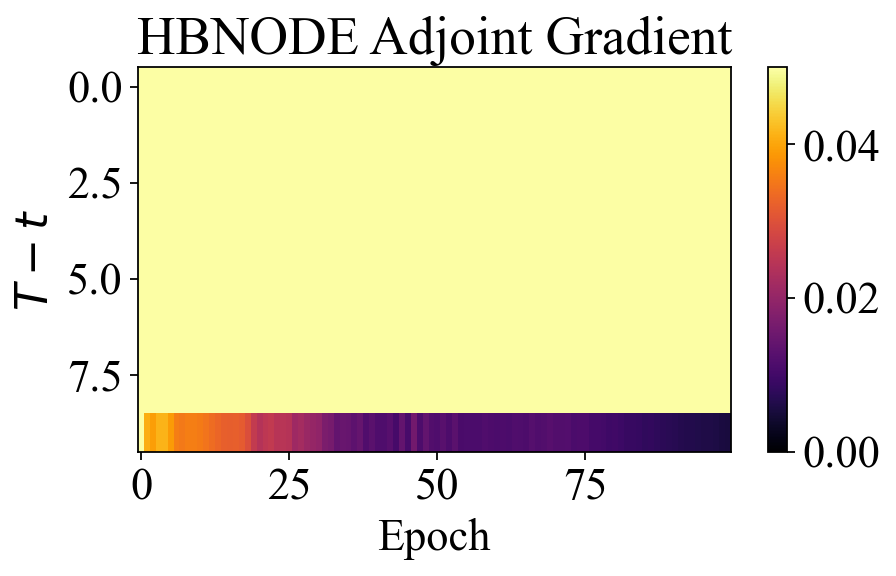

1

In [28]:
plot_AdjGrad(args.out_dir+'/pth/{}.csv'.format(args.model),args)

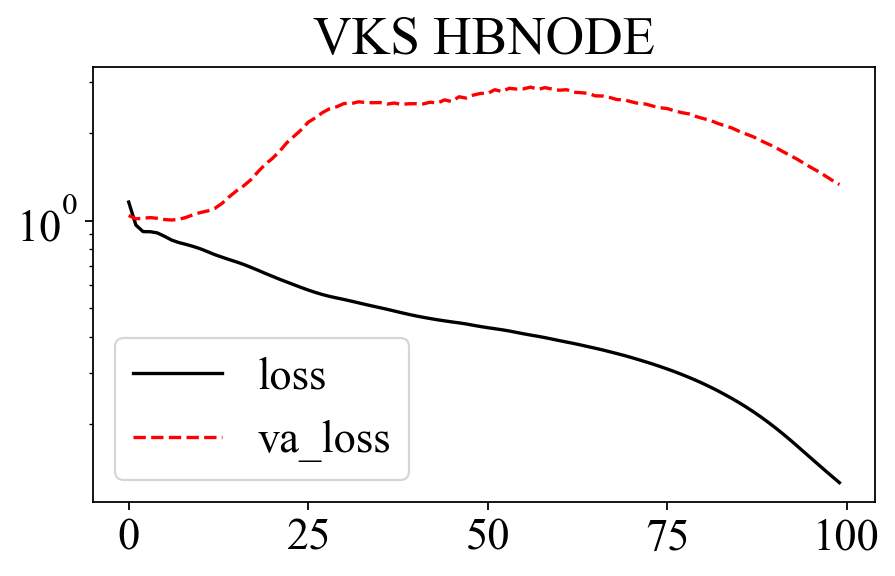

1

In [29]:
plot_Loss(args.out_dir+'/pth/{}.csv'.format(args.model),args)

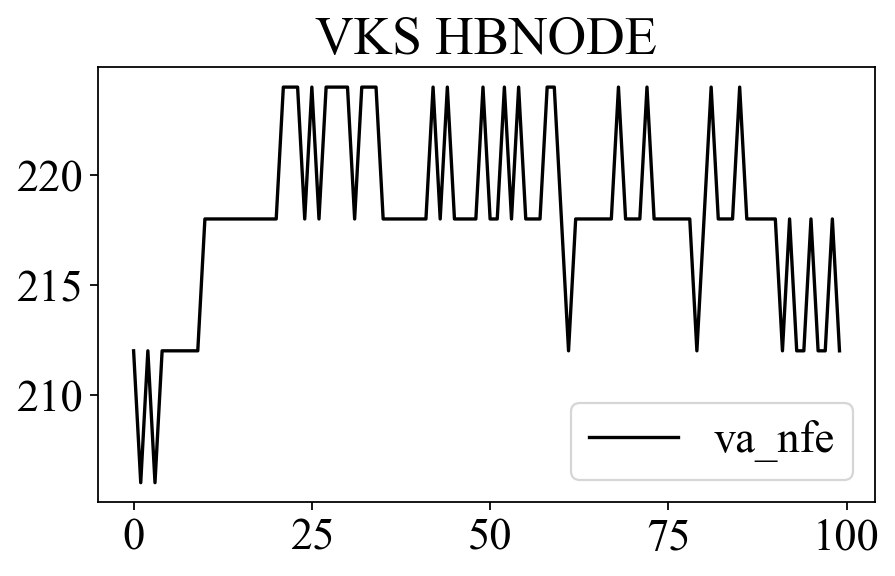

1

In [30]:
plot_NFE(args.out_dir+'/pth/{}.csv'.format(args.model),args)


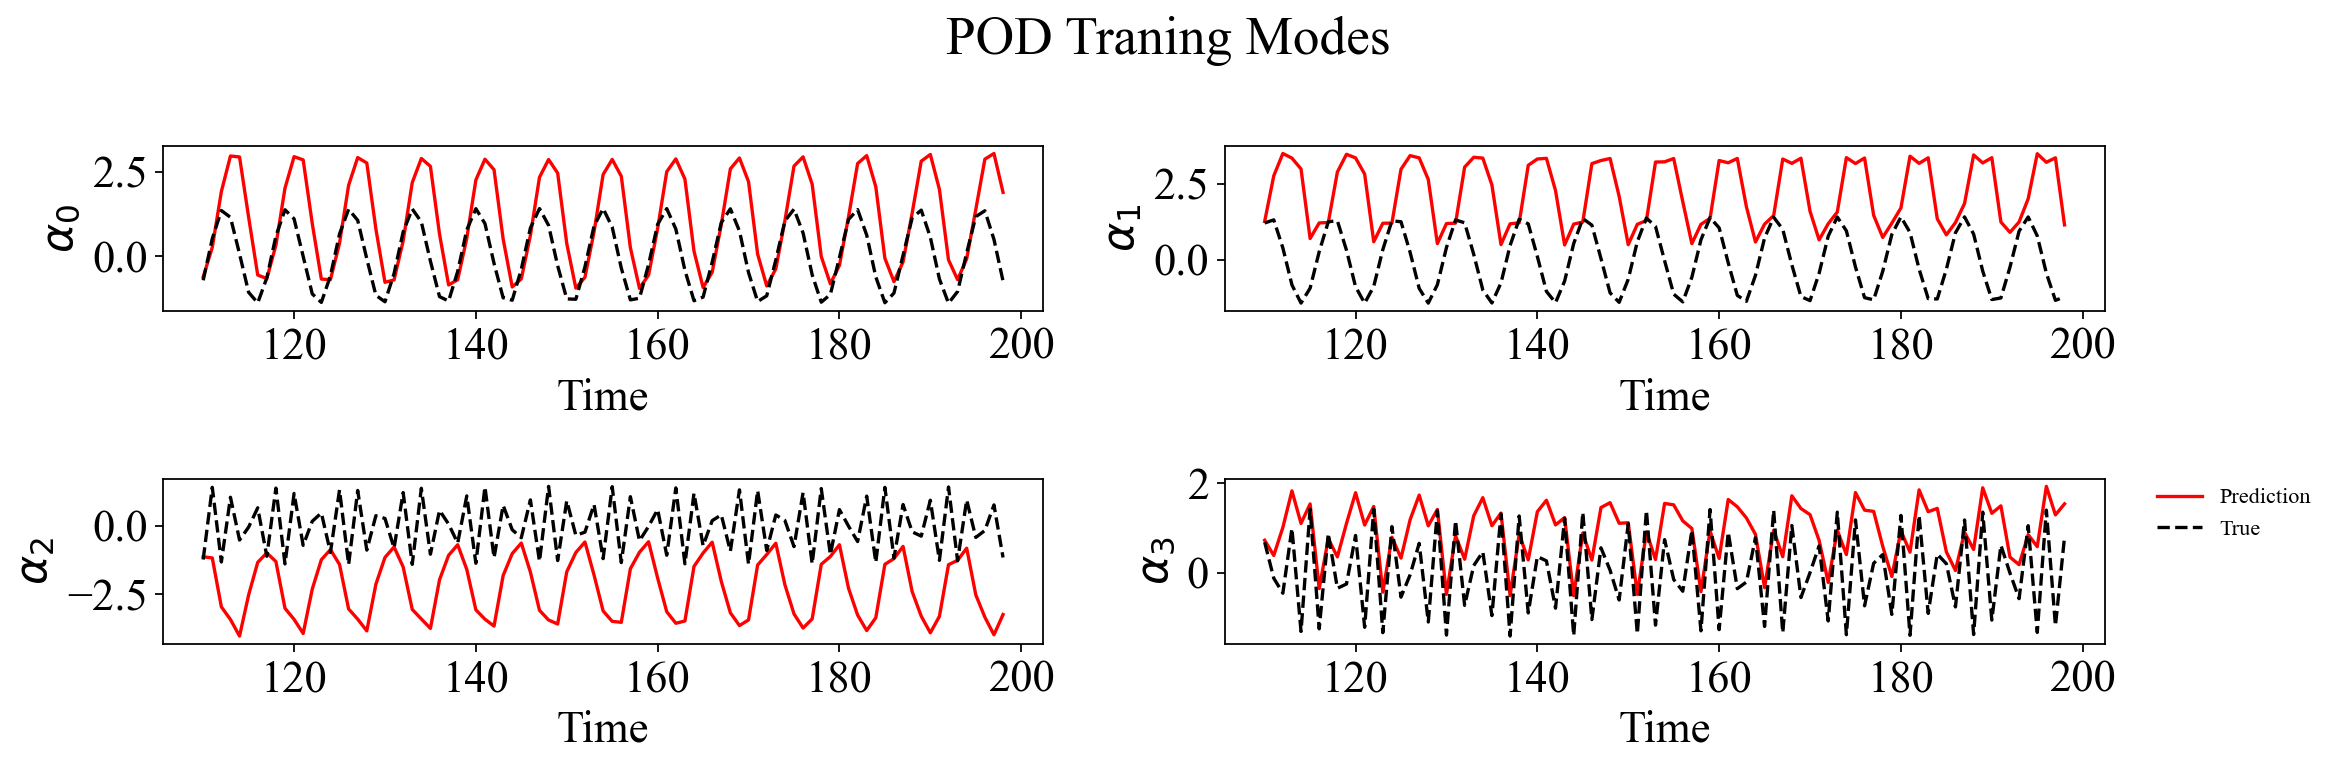

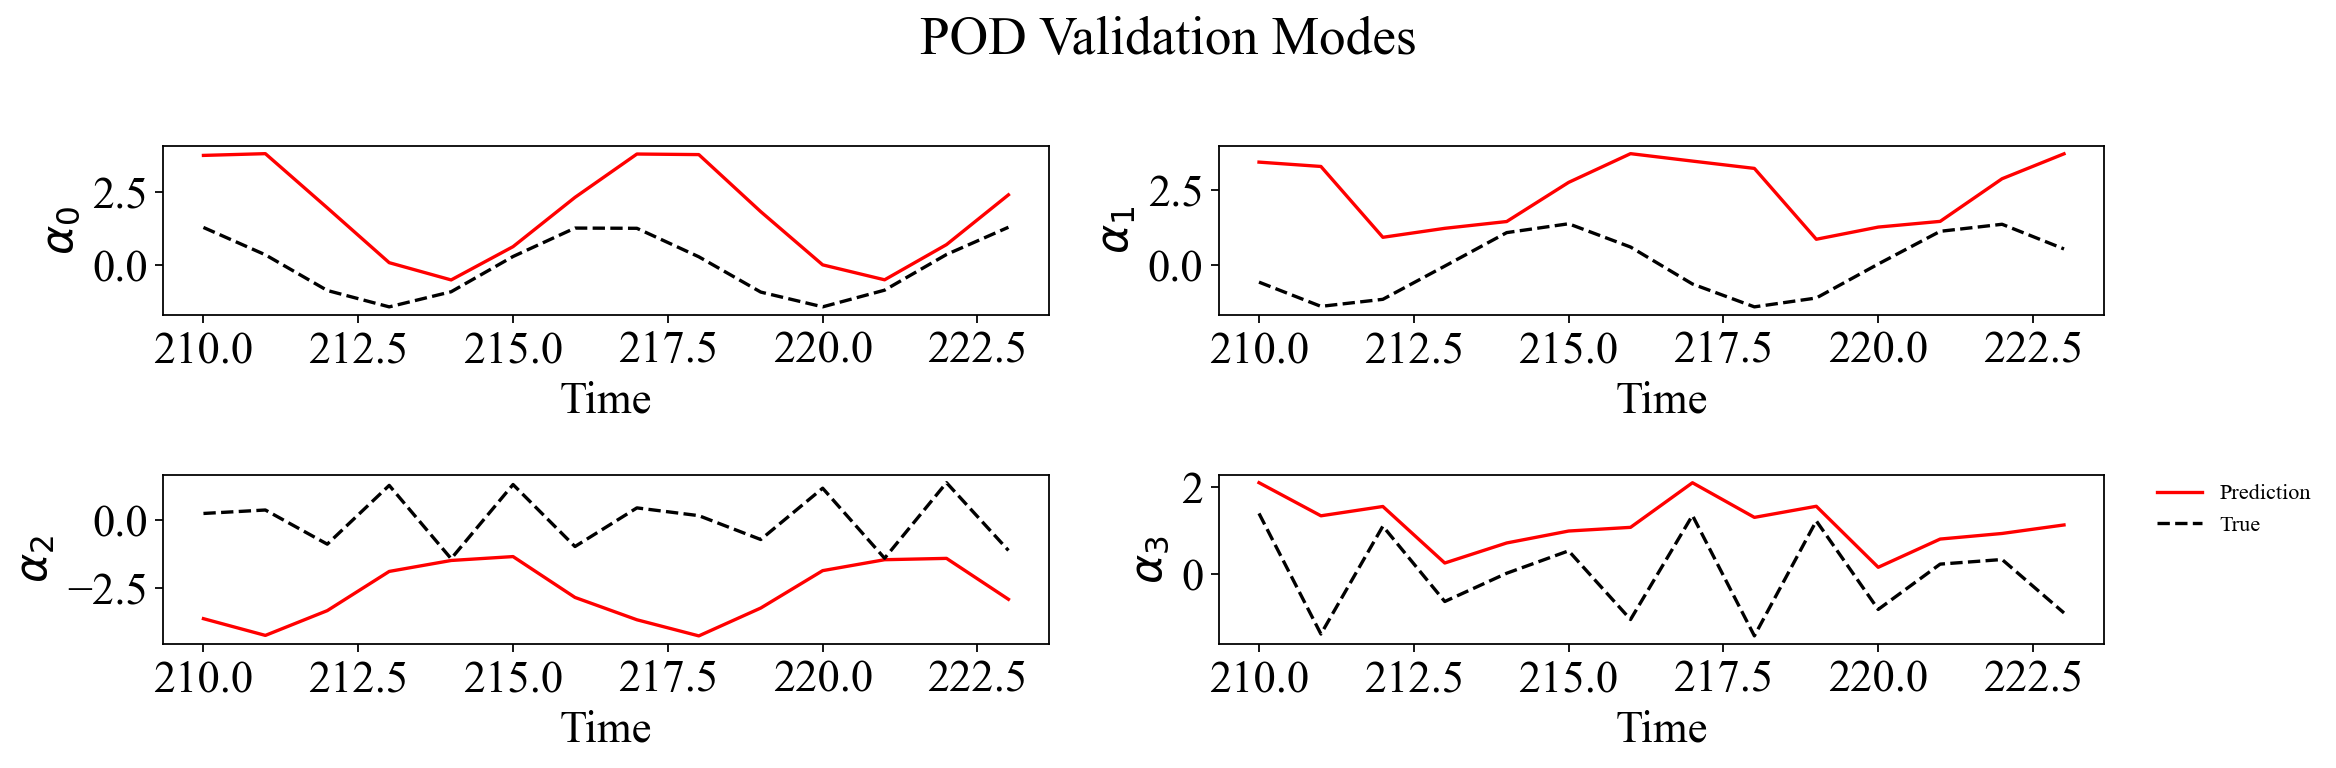

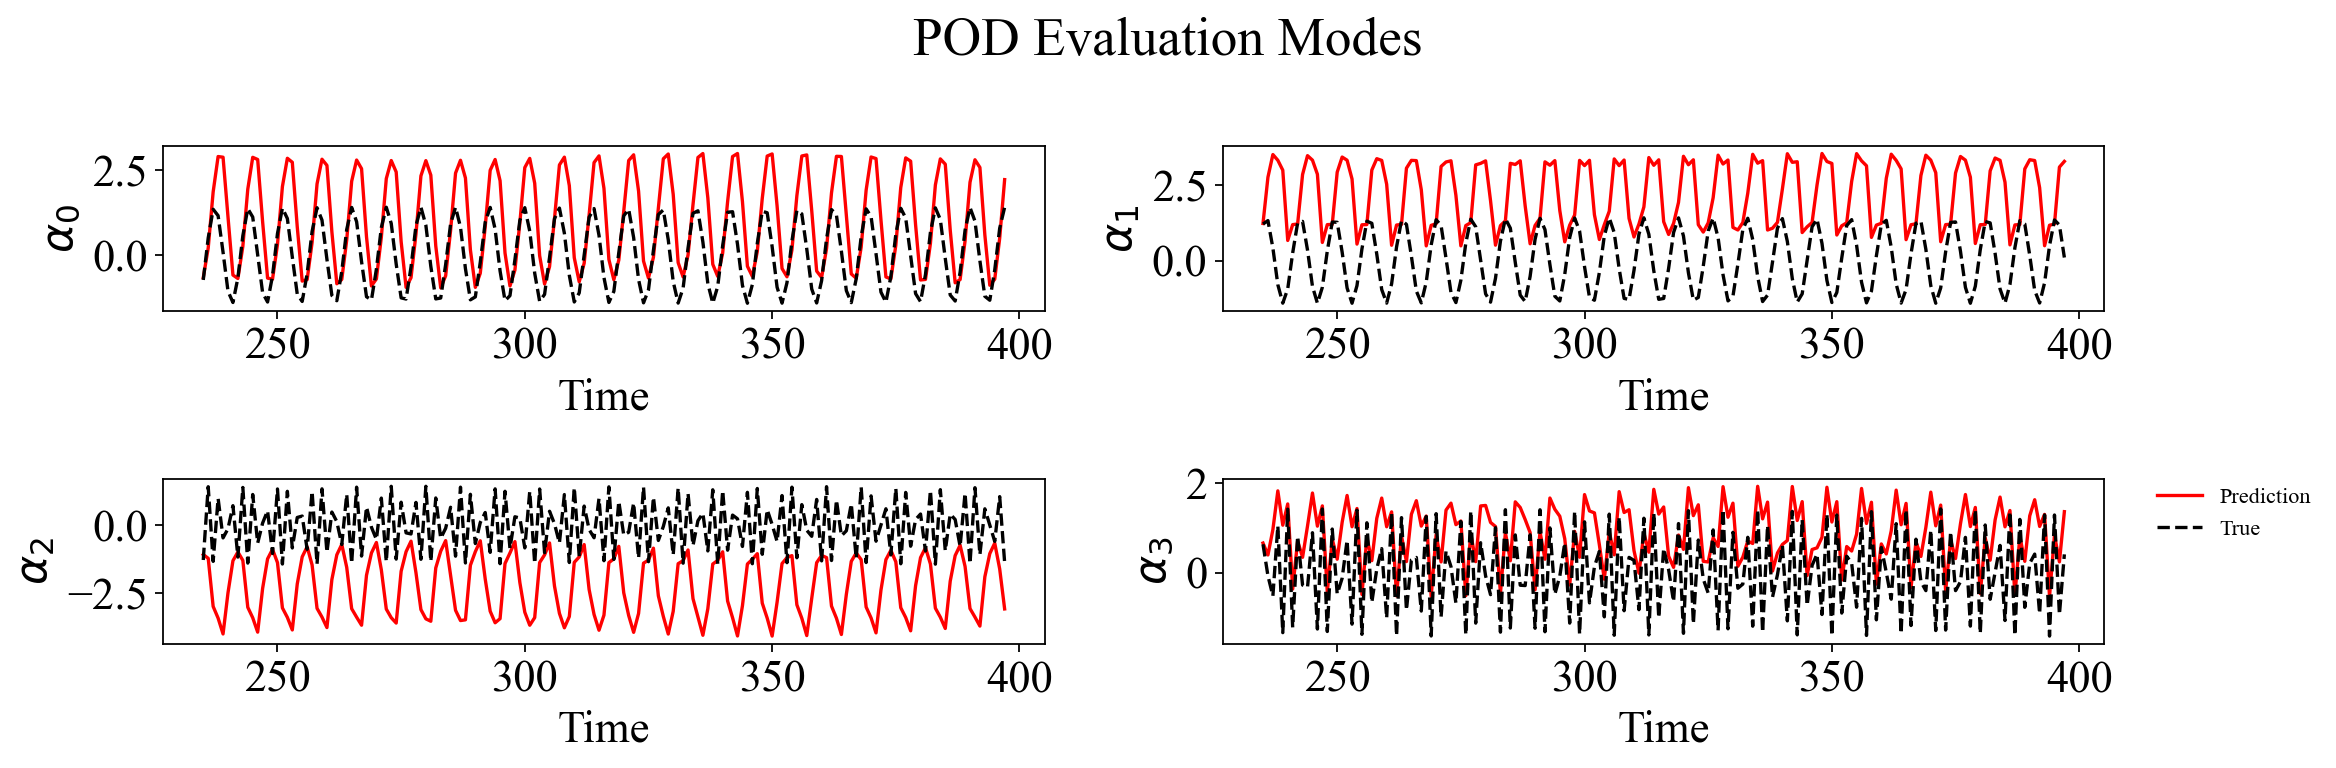

1

In [31]:
plot_Modes(DL, model, args)

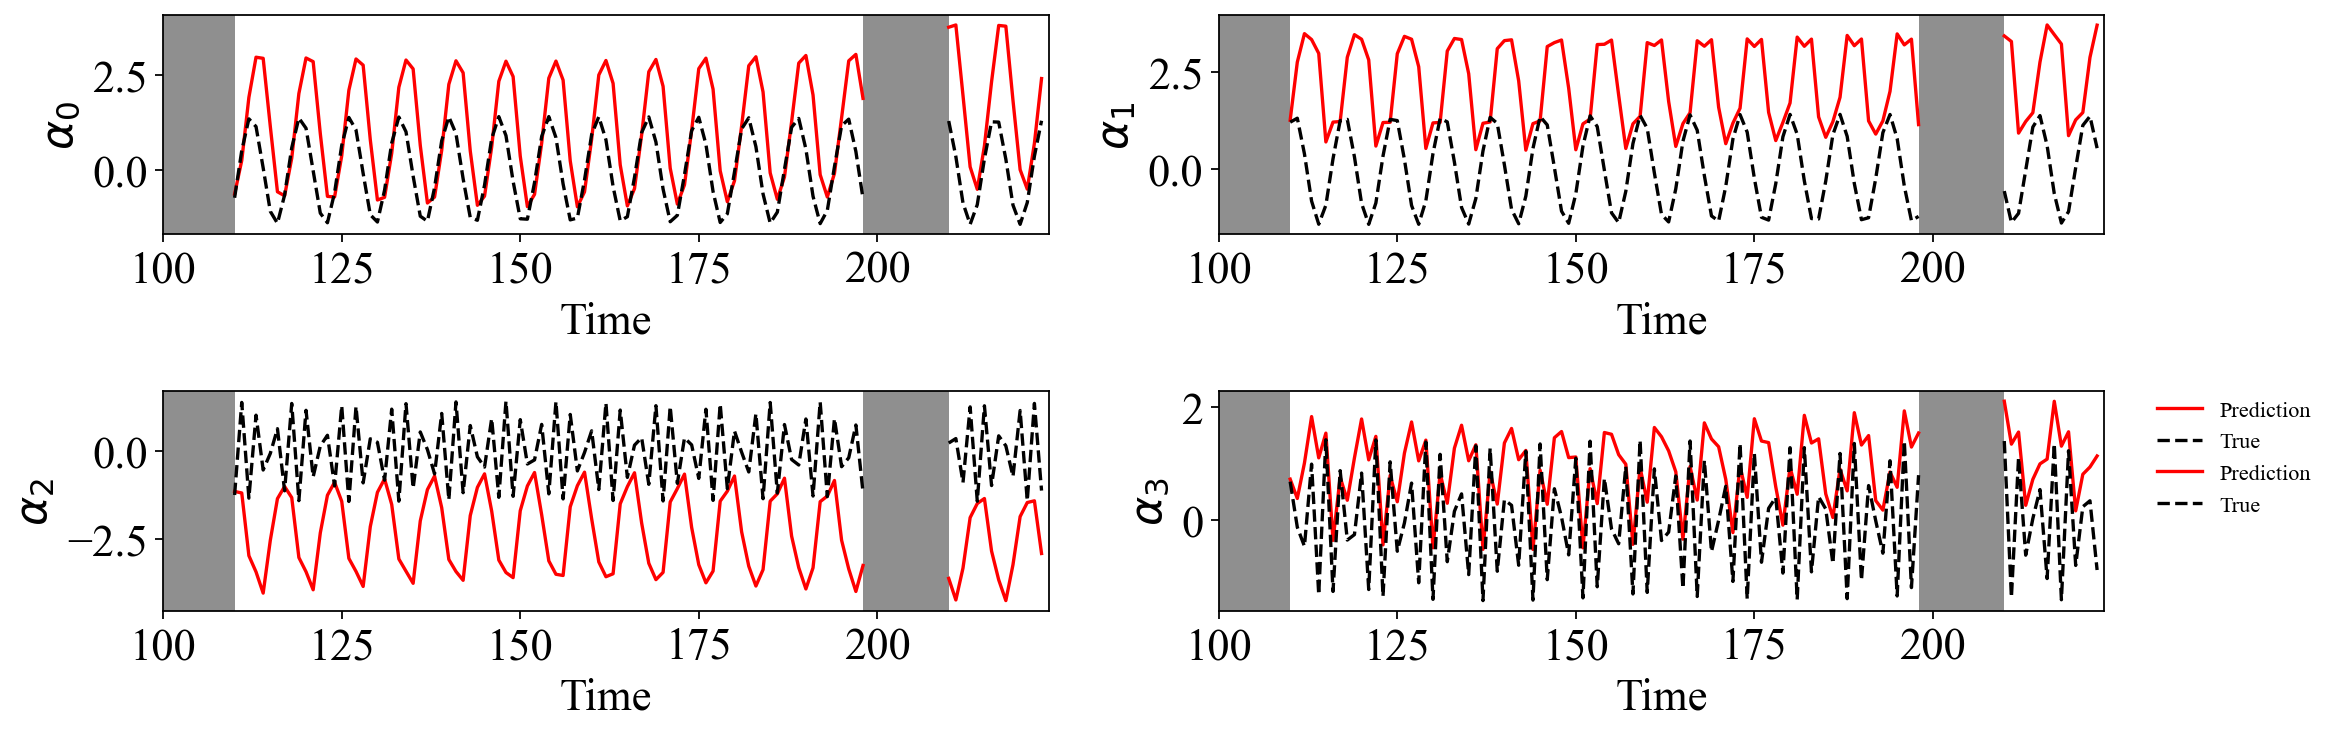

1

In [32]:
plot_ModesLong(DL, model, args)

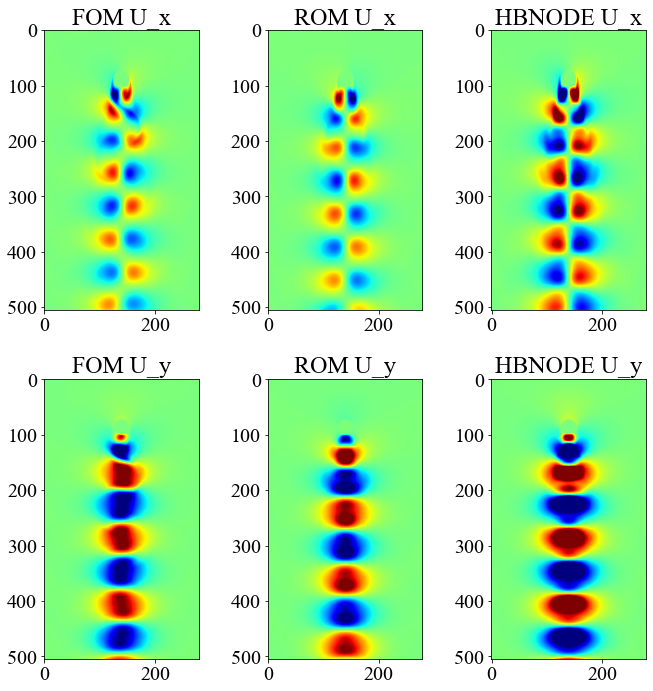

1

In [33]:
plot_Reconstruction(DL, model, args)

MovieWriter PillowWriter unavailable; using Pillow instead.


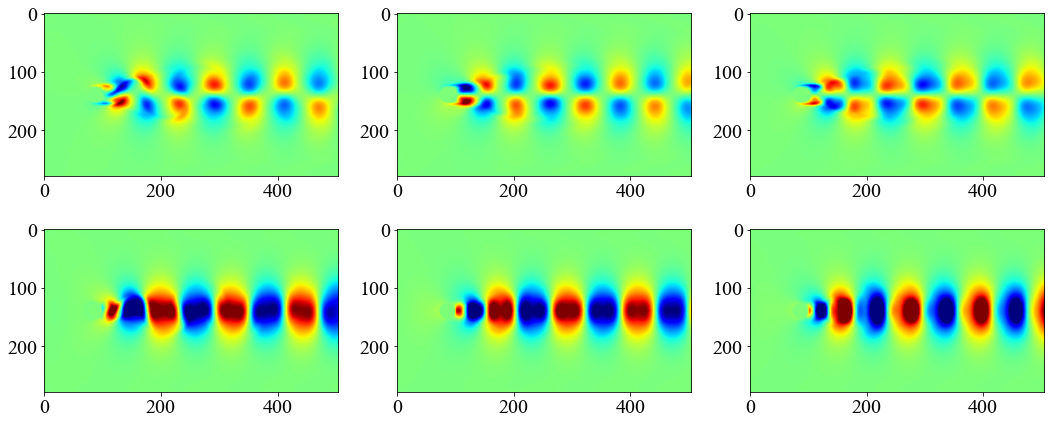

1

In [34]:
plot_Anim(DL, model, args)

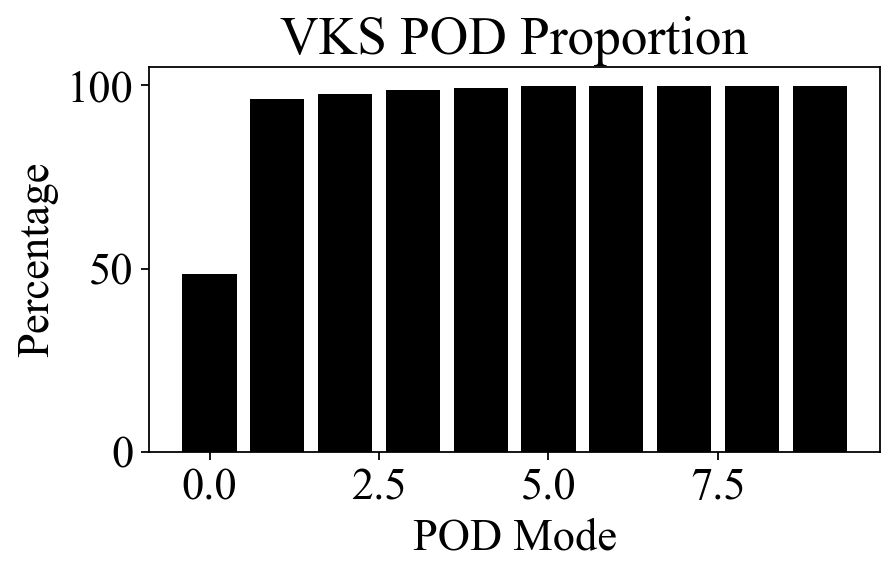

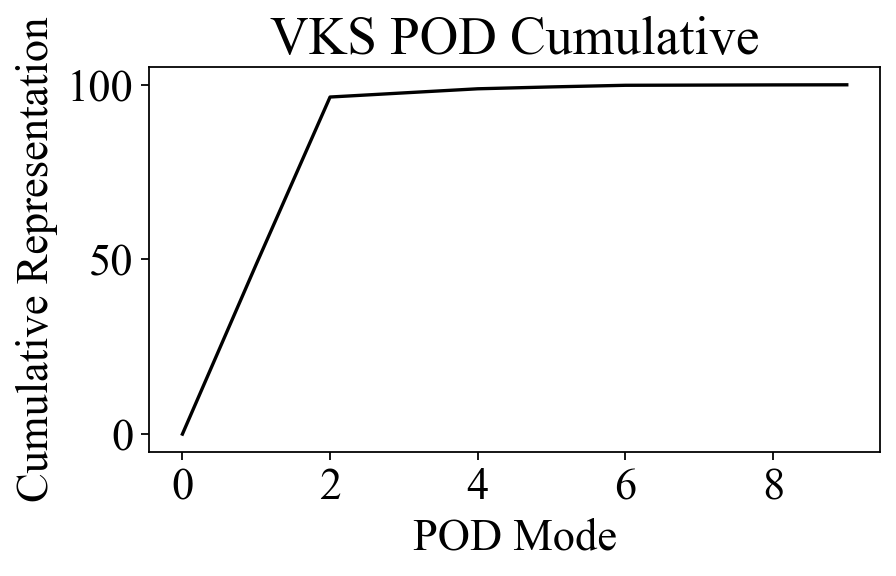

1

In [ ]:
eig_decay(DL,args)